<a href="https://colab.research.google.com/github/FadhilAndredo/GoogleColab/blob/main/Analysis_PrediksiHargaRumah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
import matplotlib.pyplot as plt

In [ ]:
# 1. Baca data (ganti path ke file Anda jika berbeda)
df = pd.read_csv('harga_rumah1.csv')
df

,price,nav-link,description,listing-location,bed,bath,carport,surface_area,building_area
0,"Rp 1,23 Miliar",https://www.rumah123.com/properti/bantul/house...,"Rumah minimalis di Banguntapan, Bantul dengan ...","Banguntapan, Bantul",5.0,3.0,1.0,235 m²,154 m²
1,"Rp 1,92 Miliar",https://www.rumah123.com/properti/sleman/house...,"Rumah strategis di Jombor, Sleman dengan 5 kam...","Jombor, Sleman",5.0,2.0,1.0,241 m²,165 m²
2,Rp 680 Juta,https://www.rumah123.com/properti/sleman/house...,"Rumah baru di Ngaglik, Sleman dengan 2 kamar t...","Ngaglik, Sleman",2.0,1.0,1.0,82 m²,60 m²
3,"Rp 1,51 Miliar",https://www.rumah123.com/properti/bantul/house...,"Rumah strategis di Srandakan, Bantul dengan 3 ...","Srandakan, Bantul",3.0,1.0,0.0,208 m²,172 m²
4,"Rp 1,30 Miliar",https://www.rumah123.com/properti/bantul/house...,"Rumah strategis di Pajangan, Bantul dengan 2 k...","Pajangan, Bantul",2.0,3.0,2.0,219 m²,151 m²
...,...,...,...,...,...,...,...,...,...
95,Rp 600 Juta,https://www.rumah123.com/properti/bantul/house...,"Rumah nyaman di Pajangan, Bantul dengan 4 kama...","Pajangan, Bantul",4.0,1.0,1.0,62 m²,38 m²
96,Rp 600 Juta,https://www.rumah123.com/properti/sleman/house...,"Rumah strategis di Moyudan, Sleman dengan 4 ka...","Moyudan, Sleman",4.0,2.0,1.0,67 m²,57 m²
97,"Rp 1,25 Miliar",https://www.rumah123.com/properti/sleman/house...,"Rumah asri di Prambanan, Sleman dengan 5 kamar...","Prambanan, Sleman",5.0,2.0,0.0,233 m²,149 m²
98,"Rp 1,69 Miliar",https://www.rumah123.com/properti/sleman/house...,"Rumah baru di Prambanan, Sleman dengan 4 kamar...","Prambanan, Sleman",4.0,1.0,0.0,249 m²,160 m²


In [ ]:
# 2. Parsing angka dari kolom price (Rp … Juta / Rp … Miliar)
def parse_price_juta(s):
    """
    Mengonversi string price:
      - 'Rp 680 Juta'       -> 680.0
      - 'Rp 1,23 Miliar'    -> 1230.0  (1,23 Miliar = 1.230 Juta)
    """
    if isinstance(s, str):
        s_clean = s.replace('.', '').replace(' ', '').replace('Rp', '')
        # Cek apakah ada kata "Miliar"
        if 'Miliar' in s_clean:
            # Ambil angka sebelum 'Miliar', ganti koma -> titik
            num = float(re.findall(r'([0-9,]+)', s_clean)[0].replace(',', '.'))
            return num * 1000  # 1 Miliar = 1000 Juta
        else:
            # Asumsikan 'Juta'
            num = float(re.findall(r'([0-9,]+)', s_clean)[0].replace(',', '.'))
            return num
    return np.nan

In [ ]:
# 3. Parsing angka dari kolom area (contoh: '235 m²' -> 235.0)
def parse_area(s):
    if isinstance(s, str):
        return float(s.replace('m²', '').replace('M²', '').strip())
    return np.nan

df['price_juta'] = df['price'].apply(parse_price_juta)
df['surface_area_num'] = df['surface_area'].apply(parse_area)
df['building_area_num'] = df['building_area'].apply(parse_area)

In [ ]:
# 4. Siapkan fitur & target
feature_cols = ['bed', 'bath', 'carport', 'surface_area_num', 'building_area_num']
X = df[feature_cols].values
y = df['price_juta'].values  # harga dalam juta

print("=== Informasi Fitur dan Target ===")
print(f"Jumlah sampel data: {X.shape[0]}")
print(f"Jumlah fitur: {X.shape[1]}")
print("\nFitur-fitur yang digunakan:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

print("\nStatistik deskriptif untuk fitur:")
print(df[feature_cols])

=== Informasi Fitur dan Target ===
Jumlah sampel data: 100
Jumlah fitur: 5

Fitur-fitur yang digunakan:
1. bed
2. bath
3. carport
4. surface_area_num
5. building_area_num

Statistik deskriptif untuk fitur:
    bed  bath  carport  surface_area_num  building_area_num
0   5.0   3.0      1.0             235.0              154.0
1   5.0   2.0      1.0             241.0              165.0
2   2.0   1.0      1.0              82.0               60.0
3   3.0   1.0      0.0             208.0              172.0
4   2.0   3.0      2.0             219.0              151.0
..  ...   ...      ...               ...                ...
95  4.0   1.0      1.0              62.0               38.0
96  4.0   2.0      1.0              67.0               57.0
97  5.0   2.0      0.0             233.0              149.0
98  4.0   1.0      0.0             249.0              160.0
99  3.0   3.0      1.0             226.0              185.0

[100 rows x 5 columns]


In [ ]:
# 5. Split data 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test : {len(X_test)}")

Jumlah data train: 80
Jumlah data test : 20


In [ ]:
# 6. Scaling fitur
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

In [ ]:
# 7. Training model MLPRegressor (BP)
model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

In [ ]:
hasil = pd.DataFrame({
    'Harga Aktual (Juta Rp)': y_test,
    'Harga Prediksi (Juta Rp)': y_pred
})
# Menampilkan hasil prediksi harga jual rumah
for i, pred in enumerate(y_pred[:10]):  # Misalnya tampilkan 10 prediksi pertama
    print(f"Prediksi Rumah ke-{i+1}: Rp {pred:,.0f} Juta")

Prediksi Rumah ke-1: Rp 2,114 Juta
Prediksi Rumah ke-2: Rp 2,252 Juta
Prediksi Rumah ke-3: Rp 1,100 Juta
Prediksi Rumah ke-4: Rp 2,220 Juta
Prediksi Rumah ke-5: Rp 1,287 Juta
Prediksi Rumah ke-6: Rp 673 Juta
Prediksi Rumah ke-7: Rp 1,464 Juta
Prediksi Rumah ke-8: Rp 598 Juta
Prediksi Rumah ke-9: Rp 825 Juta
Prediksi Rumah ke-10: Rp 1,626 Juta


In [ ]:
# 9. Evaluasi hasil prediksi
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
acc = 100 - mape

print("\n=== Evaluasi pada Test Set ===")
print(f"MAE      : {mae:.2f} juta")
print(f"RMSE     : {rmse:.2f} juta")
print(f"MAPE     : {mape:.2f} %")
print(f"Akurasi  : {acc:.2f} %")


=== Evaluasi pada Test Set ===
MAE      : 237.91 juta
RMSE     : 325.31 juta
MAPE     : 18.56 %
Akurasi  : 81.44 %


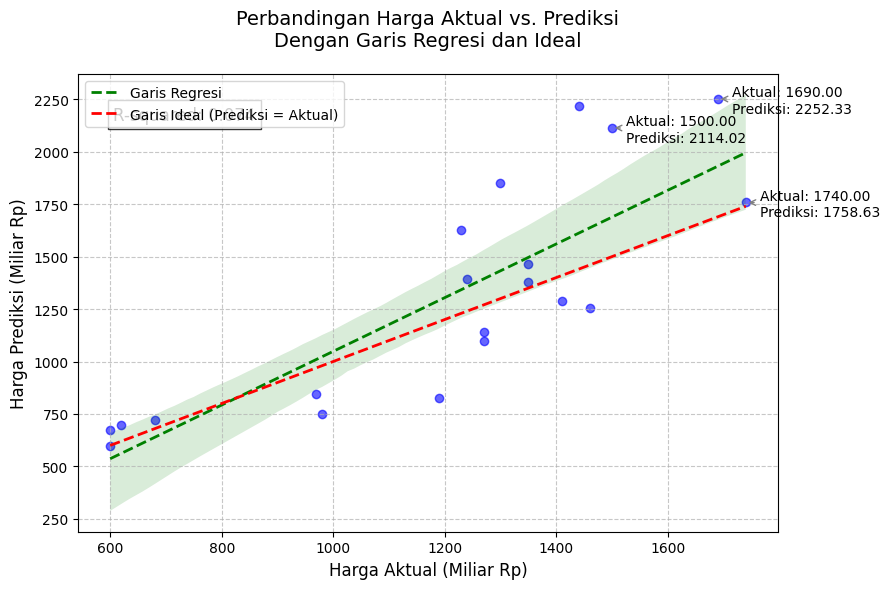

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 6))
ax = sns.regplot(x=y_test, y=y_pred,
                 scatter_kws={'alpha':0.6, 'color':'blue', 'label':'Data Aktual vs Prediksi'},
                 line_kws={'color':'green', 'linestyle':'--', 'linewidth':2, 'label':'Garis Regresi'})

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Garis Ideal (Prediksi = Aktual)')
sorted_indices = np.argsort(y_test)[-3:]  # Ambil 3 titik dengan nilai aktual terbesar
for i in sorted_indices:
    plt.annotate(f'Aktual: {y_test[i]:.2f}\nPrediksi: {y_pred[i]:.2f}',
                (y_test[i], y_pred[i]),
                textcoords="offset points",
                xytext=(10,-10),
                ha='left',
                arrowprops=dict(arrowstyle="->", color='gray'))

plt.xlabel("Harga Aktual (Miliar Rp)", fontsize=12)
plt.ylabel("Harga Prediksi (Miliar Rp)", fontsize=12)
plt.title("Perbandingan Harga Aktual vs. Prediksi\nDengan Garis Regresi dan Ideal", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.text(0.05, 0.9, f'R-squared: {r2_score(y_test, y_pred):.3f}',
         transform=ax.transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

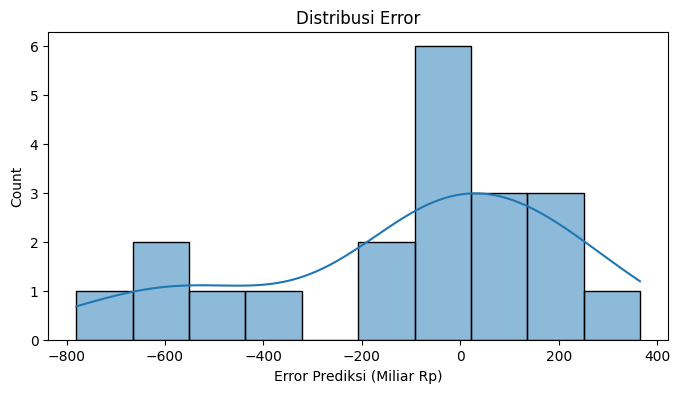

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=10)
plt.xlabel("Error Prediksi (Miliar Rp)")
plt.title("Distribusi Error")
plt.show()

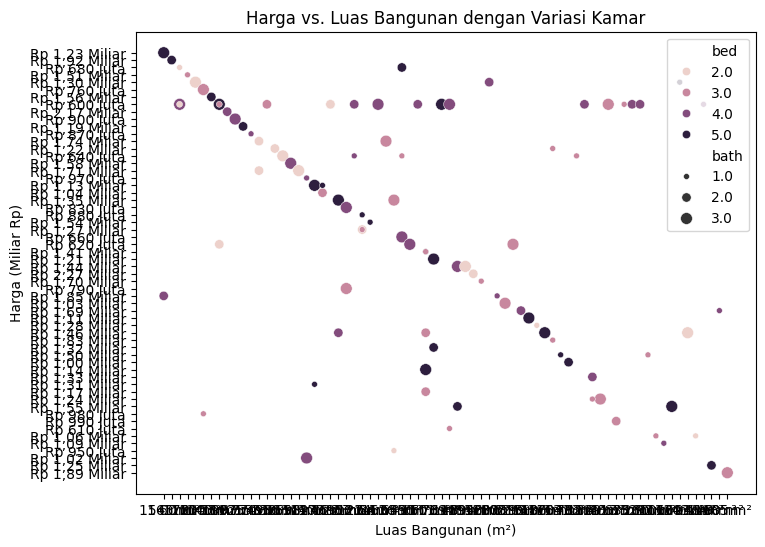

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='building_area', y='price', hue='bed', size='bath')
plt.xlabel("Luas Bangunan (m²)")
plt.ylabel("Harga (Miliar Rp)")
plt.title("Harga vs. Luas Bangunan dengan Variasi Kamar")
plt.show()